# Lab 3-1 — Weak Supervision: Labeling Functions for Email Classification

In this lab we use **Snorkel** to programmatically label a dataset of emails as `PHISHING` or `LEGITIMATE` without hand-labeling the training set.

The core idea of weak supervision is to write **labeling functions (LFs)** — noisy heuristic rules that each vote on a label. Snorkel's `LabelModel` then combines these noisy votes into a single probabilistic label per data point, accounting for each LF's accuracy and correlations between them.

## Task: Phishing Email Detection

We classify email subjects and body text into two categories:
- `LEGITIMATE` (0): normal work, personal, or transactional emails
- `PHISHING` (1): emails attempting to deceive the recipient — fake urgency, prize scams, credential harvesting

Phishing emails have distinctive linguistic patterns that make them well-suited for rule-based labeling functions.

## Data Splits

We split into:
- **Training set** (~70%): labels are withheld (`-1`). LFs will generate noisy labels for this set.
- **Test set** (~30%): gold labels are kept for final evaluation.

## 1. Setup and Loading Data

In [1]:
import os
import random
import numpy as np
import pandas as pd

# Reproducibility
random.seed(42)
np.random.seed(42)

pd.set_option("display.max_colwidth", 80)

In [5]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("emails.csv")

# Train set: drop labels (simulate unlabeled data)
# Test set: keep gold labels for evaluation
df_train_full, df_test = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label"])

df_train = df_train_full.copy()
Y_test = df_test["label"].values
Y_train_gold = df_train_full["label"].values  # keep for final comparison only

# Hide training labels — this is what weak supervision works with
df_train["label"] = -1

print(f"Training set: {len(df_train)} emails (labels hidden)")
print(f"Test set:     {len(df_test)} emails (gold labels kept)")
print(f"\nTest set class distribution:")
print(df_test["label"].value_counts().rename({0: 'LEGITIMATE', 1: 'PHISHING'}))

Training set: 56 emails (labels hidden)
Test set:     24 emails (gold labels kept)

Test set class distribution:
label
LEGITIMATE    12
PHISHING      12
Name: count, dtype: int64


## 2. Exploring the Training Data

Before writing LFs, always look at a sample to develop intuition about what patterns distinguish the classes.

In [6]:
# Look at a sample of the raw data
df_train[["subject", "body"]].sample(10, random_state=7)

,subject,body
34,Your package could not be delivered,Confirm your address and pay $1.99 redelivery fee at http://delivery-fix.net
74,Act now: IRS tax refund pending,"You are owed $1,240. Submit your SSN to process your refund today."
73,Security breach: change your password NOW,We detected a breach. Reset your password immediately at http://reset.xyz
71,Confirm your email or lose access,This is your last warning. Verify your email at http://confirm-now.biz
28,RE: Transfer confirmation needed,"Please confirm the $7,800 transfer by replying with your PIN."
19,Your PayPal account has been limited,Action required: confirm your identity at http://paypal-secure.xyz
3,Re: design review feedback,Thanks for sharing the mockups! Left some comments in Figma - please take a ...
27,Weekly engineering digest - Feb 2026,"Here's your weekly summary of PRs merged, incidents, and upcoming releases."
68,Python meetup this Thursday - register now,Join us Thursday for talks on async Python and ML pipelines. Free registration.
14,Lunch order - what do you want?,We're doing a group lunch order from Chipotle. Reply by noon.


### Observations from exploration

Looking at the data, a few patterns stand out for phishing emails:
- Urgent language: *immediately*, *urgent*, *act now*, *warning*, *alert*
- Financial bait: *$*, *win*, *free*, *prize*, *cash*
- ALL CAPS words in the subject line
- URLs or link references in the body text
- Requests for personal information: *verify*, *confirm*, *account number*, *SSN*

Legitimate emails tend to:
- Reference meetings, colleagues, schedules
- Have standard professional language
- Use `Re:` or `Fwd:` with real business context

## 3. Writing Labeling Functions

Labeling functions take a single data point (a pandas row) and return:
- `PHISHING` (1)
- `LEGITIMATE` (0)
- `ABSTAIN` (-1) — when the LF has no strong signal

Abstaining is important — it is better for an LF to abstain than to make an incorrect guess.

In [7]:
import re
from snorkel.labeling import labeling_function, LabelingFunction, PandasLFApplier, LFAnalysis

ABSTAIN = -1
LEGITIMATE = 0
PHISHING = 1

### a) Keyword-based LFs

In [8]:
# Urgency language in subject or body
@labeling_function()
def lf_urgent_keywords(x):
    urgent = ["urgent", "immediately", "act now", "right away", "last chance", "final notice", "warning"]
    text = (x.subject + " " + x.body).lower()
    return PHISHING if any(w in text for w in urgent) else ABSTAIN

# Financial bait keywords
@labeling_function()
def lf_money_keywords(x):
    money = ["free", "win", "won", "prize", "cash", "reward", "voucher", "gift card", "claim"]
    text = (x.subject + " " + x.body).lower()
    return PHISHING if any(w in text for w in money) else ABSTAIN

# Account/credential harvesting language
@labeling_function()
def lf_credential_keywords(x):
    creds = ["verify", "confirm your", "account number", "bank details", "card number", "password", "ssn"]
    text = (x.subject + " " + x.body).lower()
    return PHISHING if any(w in text for w in creds) else ABSTAIN

# Legitimate meeting/work references
@labeling_function()
def lf_work_keywords(x):
    work = ["meeting", "standup", "calendar", "agenda", "onboarding", "feedback", "invoice", "schedule", "team"]
    text = (x.subject + " " + x.body).lower()
    return LEGITIMATE if any(w in text for w in work) else ABSTAIN

### b) Regex-based LFs

In [9]:
# Dollar amounts — phishing often baits with specific sums
@labeling_function()
def lf_dollar_amount(x):
    return PHISHING if re.search(r'\$[\d,]+', x.subject + " " + x.body) else ABSTAIN

# Suspicious URLs — phishing often uses non-standard domains
@labeling_function()
def lf_suspicious_url(x):
    return PHISHING if re.search(r'http[s]?://[\w\-]+\.(xyz|biz|info|co|net/)', x.body, re.I) else ABSTAIN

# Legitimate Re:/Fwd: with work context
@labeling_function()
def lf_reply_forward(x):
    if re.match(r'^(re|fwd|fw):', x.subject, re.I):
        work_words = ["contract", "review", "pr", "meeting", "documents", "proposal", "report", "salary"]
        if any(w in x.body.lower() for w in work_words):
            return LEGITIMATE
    return ABSTAIN

### c) Structural / heuristic LFs

In [10]:
# ALL CAPS words in subject — common spam pattern
@labeling_function()
def lf_caps_subject(x):
    words = x.subject.split()
    caps_count = sum(1 for w in words if w.isupper() and len(w) > 2)
    return PHISHING if caps_count >= 2 else ABSTAIN

# Excessive exclamation marks
@labeling_function()
def lf_exclamation(x):
    return PHISHING if (x.subject + x.body).count("!") >= 3 else ABSTAIN

# Short, normal-length subject — typical of legitimate email
@labeling_function()
def lf_normal_subject_length(x):
    word_count = len(x.subject.split())
    return LEGITIMATE if 3 <= word_count <= 8 else ABSTAIN

## 4. Applying LFs and Analyzing Coverage

In [11]:
lfs = [
    lf_urgent_keywords,
    lf_money_keywords,
    lf_credential_keywords,
    lf_work_keywords,
    lf_dollar_amount,
    lf_suspicious_url,
    lf_reply_forward,
    lf_caps_subject,
    lf_exclamation,
    lf_normal_subject_length,
]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test  = applier.apply(df=df_test)

100%|██████████| 24/24 [00:00<00:00, 11989.43it/s]


In [12]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y=Y_train_gold)

D:\NEU\IE7374_Lab\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_urgent_keywords,0,[1],0.178571,0.178571,0.178571,10,0,1.000000
lf_money_keywords,1,[1],0.214286,0.214286,0.214286,8,4,0.666667
lf_credential_keywords,2,[1],0.232143,0.232143,0.232143,13,0,1.000000
lf_work_keywords,3,[0],0.250000,0.250000,0.035714,13,1,0.928571
lf_dollar_amount,4,[1],0.285714,0.285714,0.285714,14,2,0.875000
lf_suspicious_url,5,[1],0.107143,0.107143,0.107143,6,0,1.000000
lf_reply_forward,6,[0],0.071429,0.071429,0.053571,2,2,0.500000
lf_caps_subject,7,[1],0.053571,0.053571,0.053571,3,0,1.000000
lf_exclamation,8,[1],0.035714,0.035714,0.035714,2,0,1.000000
lf_normal_subject_length,9,[0],1.000000,0.821429,0.589286,28,28,0.500000


**Reading the summary:**
- **Coverage**: fraction of training points the LF labels (non-abstain)
- **Overlaps**: fraction of points where this LF and at least one other agree
- **Conflicts**: fraction of points where this LF and another disagree
- **Emp. Acc.**: estimated accuracy against the gold labels (only shown when gold labels are provided — in practice we wouldn't have these)

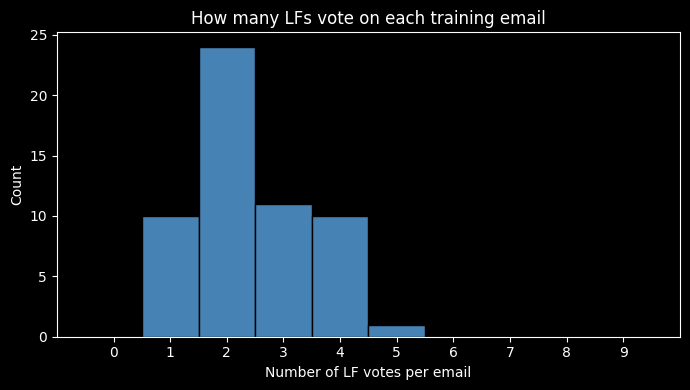

In [13]:
import matplotlib.pyplot as plt

def plot_label_frequency(L, title=""):
    counts = (L != ABSTAIN).sum(axis=1)
    plt.figure(figsize=(7, 4))
    plt.hist(counts, bins=range(L.shape[1] + 1), edgecolor='black', color='steelblue', align='left')
    plt.xlabel("Number of LF votes per email")
    plt.ylabel("Count")
    plt.title(title or "LF vote distribution")
    plt.xticks(range(L.shape[1]))
    plt.tight_layout()
    plt.show()

plot_label_frequency(L_train, "How many LFs vote on each training email")

## 5. Combining LF Votes with the Label Model

A simple majority vote treats all LFs equally. Snorkel's `LabelModel` is smarter — it estimates each LF's accuracy and learns correlations between them, producing a better set of probabilistic labels.

In [14]:
from snorkel.labeling.model import MajorityLabelVoter, LabelModel

# Baseline: majority vote
majority_model = MajorityLabelVoter(cardinality=2)
preds_majority = majority_model.predict(L=L_test)
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"Majority vote accuracy: {majority_acc * 100:.1f}%")

Majority vote accuracy: 87.5%


In [15]:
# Label Model: learns LF weights and correlations
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=300, log_freq=100, seed=42)

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"Label Model accuracy:  {label_model_acc * 100:.1f}%")

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/300 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=1.484]
INFO:root:[100 epochs]: TRAIN:[loss=0.027]
100%|██████████| 300/300 [00:00<00:00, 1941.57epoch/s]
INFO:root:Finished Training


Label Model accuracy:  83.3%


## 6. Training a Downstream Classifier

The `LabelModel` produces probabilistic labels for the unlabeled training set. We now use these as training labels for a `LogisticRegression` classifier on bag-of-words features — this classifier can generalize beyond the LF heuristics to unseen patterns.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Generate probabilistic labels for training set from the Label Model
probs_train = label_model.predict_proba(L=L_train)
preds_train  = label_model.predict(L=L_train, tie_break_policy="random")

# Bag-of-words features on subject + body
df_train["text"] = df_train["subject"] + " " + df_train["body"]
df_test["text"]  = df_test["subject"]  + " " + df_test["body"]

vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=1)
X_train = vectorizer.fit_transform(df_train["text"])
X_test  = vectorizer.transform(df_test["text"])

In [17]:
clf = LogisticRegression(C=1.0, solver="liblinear", random_state=42)
clf.fit(X_train, preds_train)

preds_clf = clf.predict(X_test)
clf_acc = accuracy_score(Y_test, preds_clf)

print(f"Logistic Regression (LabelModel labels) accuracy: {clf_acc * 100:.1f}%")
print()
print(classification_report(Y_test, preds_clf, target_names=["LEGITIMATE", "PHISHING"]))

Logistic Regression (LabelModel labels) accuracy: 79.2%

              precision    recall  f1-score   support

  LEGITIMATE       0.89      0.67      0.76        12
    PHISHING       0.73      0.92      0.81        12

    accuracy                           0.79        24
   macro avg       0.81      0.79      0.79        24
weighted avg       0.81      0.79      0.79        24



## Summary

| Method | Test Accuracy |
|---|---|
| Majority Vote | see above |
| Label Model | see above |
| Logistic Regression (LM labels) | see above |

**Key takeaways:**
- We labeled the entire training set programmatically — no manual annotation
- LFs have varied coverage and accuracy; the Label Model accounts for this
- The downstream classifier generalizes beyond the LF rules to new phishing patterns
- In practice the LF rules would be refined iteratively as you see errors